<a href="https://colab.research.google.com/github/gijsbarmentlo/Small-DataScience-Projects/blob/master/modeles_previsionnel_pytorch_compute_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & metadata

### imports

In [1]:
!pip install mysql-connector-python
import mysql.connector as connection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm
import datetime

#from google.colab import drive
#drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 44.4 MB/s eta 0:00:00


In [2]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

### Metadata

In [6]:
from google.colab import userdata

database_password = userdata.get('ensylog_db_readonly_password')
database_user = userdata.get('ensylog_db_readonly_user')
database_url = userdata.get('ensylog_db_readonly_host')

In [7]:
reference_period_start = '2022-04-01'
reference_period_end = '2023-04-01'
id_site_global =  15227 #1633   Brico depot Lievin, other id 16064

## Create model


In [8]:
class PrevisionalModelReluSimple(torch.nn.Module):

    def __init__(self):
      super(PrevisionalModelReluSimple, self).__init__()

      self.linear1 = torch.nn.Linear(1, 4)
      self.relu1 = torch.nn.ReLU()
      self.linear2 = torch.nn.Linear(4, 1)

      self.linear1.weight.requires_grad = False

      # 1. Initialize weights with a ReLU-specific method (e.g., He initialization)
      torch.nn.init.kaiming_normal_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
      torch.nn.init.kaiming_normal_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

      # 2. Initialize biases (you can use zeros or other values)
      #self.linear1.bias.data.fill_(-10.0)
      #self.linear2.bias.data.fill_(-10.0)

    def forward(self, x):
      x = self.linear1(x)
      x = self.relu1(x)
      x = self.linear2(x)
      return x

    def set_custom_weights_open(self,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p):
      custom_weights1 = torch.tensor([[1.0], [1.0], [1.0], [1.0]]) #pass along temerature value without alteration
      custom_biases1 = torch.tensor([-m, -n, -o, -p]) #different breakpoints of our linear piecewise estimator m,n,o, p
      self.linear1.weight.data = custom_weights1
      self.linear1.bias.data = custom_biases1

      custom_weights2 = torch.tensor([[a, c-a, e-c, -e]]) #defines values of successive slopes, the second value is the second slope minus the first slope as they are applied additively  (alpha, beta-alpha, delta-beta)
      custom_biases2 = torch.tensor([a*m+b]) #this is the constant value at negative temperatures
      self.linear2.weight.data = custom_weights2
      self.linear2.bias.data = custom_biases2

    def set_custom_weights_closed(self,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p):
      custom_weights1 = torch.tensor([[1.0], [1.0], [1.0], [1.0]]) #pass along temerature value without alteration
      custom_biases1 = torch.tensor([-m, -n, -o, -p]) #different breakpoints of our linear piecewise estimator m,n,o, p
      self.linear1.weight.data = custom_weights1
      self.linear1.bias.data = custom_biases1

      custom_weights2 = torch.tensor([[g, i-g, k-i, -k]]) #defines values of successive slopes, the second value is the second slope minus the first slope as they are applied additively  (alpha, beta-alpha, delta-beta)
      custom_biases2 = torch.tensor([g*m+h]) #this is the constant value at negative temperatures
      self.linear2.weight.data = custom_weights2
      self.linear2.bias.data = custom_biases2

## Get data from DB

#### Get consumption, opening hours, exceptional opening and closing days

In [9]:
## Get bdd_nom which we need to build the consumption data query
def get_bdd_nom(id_site_global):
  sql_query = f"SELECT bdd_nom from `global`.bdd_client WHERE k IN (SELECT k FROM `global`.client WHERE id_client IN (SELECT id_client FROM `global`.sites WHERE id_site = {id_site_global}))"
  # Get bdd nom
  bdd_nom_df = pd.DataFrame()
  try:
      mydb = connection.connect(host=database_url,user=database_user, passwd=database_password,use_pure=True)
      bdd_nom_df = pd.read_sql(sql_query,mydb)
      mydb.close() #close the connection
  except Exception as e:
      mydb.close()
      print(str(e))

  bdd_nom = bdd_nom_df['bdd_nom'].iloc[0]
  return bdd_nom

In [10]:
def get_dfs_from_db(id_site_global, reference_period_start, reference_period_end):
  sql_query_horaires = f"SELECT day,	ouverture,fermeture FROM global.previsionnels_horaires where id_site = {id_site_global}" #excluding pause time for now debut_pause,	fin_pause,
  sql_query_fermetures_exceptionnelles = f"SELECT date FROM global.previsionnels_horaires_fermetures_exceptionnelles where id_site = {id_site_global}"
  sql_query_horaires_ouvertures_exceptionnelles = f"SELECT date, ouverture, fermeture FROM global.previsionnels_horaires_ouvertures_exceptionnelles where id_site = {id_site_global}"
  sql_query_temperature = f"SELECT datetime, temperature FROM global.donnees_meteo_darksky where id_station = (select id_station_darksky from global.sites where id_site = {id_site_global}) and datetime > '{reference_period_start}' and datetime < '{reference_period_end}'"
  get_consumption_query = f"SELECT `datetime`, general as consumption from `{get_bdd_nom(id_site_global)}`.donnees_conso WHERE id_site IN (SELECT id_ensylog FROM `global`.sites WHERE id_site = {id_site_global}) AND datetime > '{reference_period_start}' and datetime < '{reference_period_end}'"

  try:
      mydb = connection.connect(host=database_url,user=database_user, passwd=database_password,use_pure=True)
      df_horaires_ouverture = pd.read_sql(sql_query_horaires,mydb)
      df_fermetures_exceptionnelles = pd.read_sql(sql_query_fermetures_exceptionnelles,mydb)
      df_horaires_ouvertures_exceptionnelles = pd.read_sql(sql_query_horaires_ouvertures_exceptionnelles,mydb)
      df_temperature = pd.read_sql(sql_query_temperature,mydb)
      df_consumption = pd.read_sql(get_consumption_query,mydb)
      mydb.close() #close the connection

  except Exception as e:
      mydb.close()
      print(str(e))

  return df_horaires_ouverture, df_fermetures_exceptionnelles, df_horaires_ouvertures_exceptionnelles, df_temperature, df_consumption

#### Get model parameters

In [11]:
def get_model_parameters_df(id_site_global):
  sql_query = f"SELECT a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p FROM global.previsionnels_modeles_variables where id_modele = (select id_modele from global.previsionnels_modeles where id_site = {id_site_global} and id_categorie = 1)"

  try:
      mydb = connection.connect(host=database_url,user=database_user, passwd=database_password,use_pure=True)
      query = sql_query
      df_model_params = pd.read_sql(sql_query,mydb)
      mydb.close() #close the connection
  except Exception as e:
      mydb.close()
      print(str(e))

  return df_model_params

## Process data from DB to create training dataframe

### Create is_open feature

The order of application is standard opening hours, closing days then exceptional openaning hours (ie. if it is specified that the store is closed on the 01/01/2023 and exceptionally open the 01/01/2023 from 1PM to 6PM then the opening hours override the day of closure)

In [12]:
def create_is_open_feature(df_input, df_horaires_ouverture, df_fermetures_exceptionnelles, df_horaires_ouvertures_exceptionnelles):

  def is_usual_open_np(weekday, hour, minute, second): #no handlong of lunchbreak for now
    dt_timedelta = datetime.timedelta(hours = hour, minutes = minute, seconds = second)
    #dt_day = row.weekday + 1 # monday is 0 with +1 monday is 1 to match formatting ofopening_hours_df

    has_opened = dt_timedelta >= opening_hours_np[weekday][1]
    has_not_closed = dt_timedelta < opening_hours_np[weekday][2]

    is_open = has_opened and has_not_closed

    return is_open

  def is_exceptional_open(date, hour, minute, second):
    dt_timedelta = datetime.timedelta(hours = hour, minutes = minute, seconds = second)
    #dt_day = row.weekday + 1 # monday is 0 with +1 monday is 1 to match formatting ofopening_hours_df

    #has_opened = dt_timedelta > exceptional_opening_df[exceptional_opening_df['date']==date]['ouverture'].iloc[0]
    has_opened = dt_timedelta >= df_horaires_ouvertures_exceptionnelles.loc[df_horaires_ouvertures_exceptionnelles['date']==date, 'ouverture'].iloc[0]
    #has_not_closed = dt_timedelta < exceptional_opening_df[exceptional_opening_df['date']==date]['fermeture'].iloc[0]
    has_not_closed = dt_timedelta < df_horaires_ouvertures_exceptionnelles.loc[df_horaires_ouvertures_exceptionnelles['date']==date,'fermeture'].iloc[0]

    is_open = has_opened and has_not_closed

    return is_open

  # Create intermediate values for calculating is_open feature with series.dt accessor because it is much faster than elementwise operations on dataframe
  df_input['date'] = df_input['datetime'].dt.date
  df_input['hour'] = df_input['datetime'].dt.hour
  df_input['minute'] = df_input['datetime'].dt.minute
  df_input['second'] = df_input['datetime'].dt.second
  df_input['weekday'] = df_input['datetime'].dt.weekday

  # The order of application is important (first usual opening hours for the store, then exceptional closures, then exceptional opening hours) so that they override each other correctly
  #(eg. a store that is exceptinonaly close the 01/01/2023 and exceptionally open the 01/01/2023 from 1PM to 5PM will be is_open between 1 and 5PM because it is applied later)
  opening_hours_np = df_horaires_ouverture.sort_values(by=['day']).to_numpy()

  ## computing opening bool based on usual opening hours
  df_input['is_open'] = df_input.apply(lambda x : is_usual_open_np(x.weekday,x.hour,x.minute,x.second), axis=1)

  ## changing bool to closed on exceptional closure days
  df_input.loc[df_input['date'].isin(df_fermetures_exceptionnelles['date']),'is_open'] = False

  ## changing bool based on exceptional opening hours
  ##It is important to apply is_exceptional_open only when the location is closed (filtered by & (consumption_df['is_open_np']==False))
  ##because if we only filter on date, the normal opening hours will be overridden to is_open = false
  df_input.loc[df_input['date'].isin(df_horaires_ouvertures_exceptionnelles['date']) & (df_input['is_open']==False),'is_open'] = df_input.loc[df_input['date'].isin(df_horaires_ouvertures_exceptionnelles['date']) & (df_input['is_open']==False),:].apply(lambda x : is_exceptional_open(x.date,x.hour,x.minute,x.second), axis = 1)

  # drop needless columns

  df_input.drop(['date', 'hour', 'minute', 'second', 'weekday'], axis = 1, inplace = True)

  return df_input

### Resample dataframe to hourly

In [13]:
def resample_df_hourly(input_df):
  # Assuming 'timestamp' is the name of your timestamp column
  input_df['datetime'] = pd.to_datetime(input_df['datetime'])

  # Set the timestamp column as the DataFrame's index
  temp_df = input_df.set_index('datetime')

  # Resample the data to hourly intervals and apply the sum aggregation
  hourly_df = temp_df['consumption'].resample('H').sum()

  # Reset the index to have the timestamp as a regular column
  hourly_df = hourly_df.reset_index()

  hourly_df = hourly_df[hourly_df['consumption']!=0]

  return hourly_df

## Create training df using all functions above

In [14]:
def create_train_df(id_site_global, reference_period_start, reference_period_end):
  df_horaires_ouverture, df_fermetures_exceptionnelles, df_horaires_ouvertures_exceptionnelles, df_temperature, df_consumption = get_dfs_from_db(id_site_global, reference_period_start, reference_period_end)

  ## adding is_open feature based on opening hours and days
  df_temperature = create_is_open_feature(df_temperature, df_horaires_ouverture, df_fermetures_exceptionnelles, df_horaires_ouvertures_exceptionnelles)

  #consumption data is in 10 minute format, agregating consumption per hour
  df_consumption_hourly = resample_df_hourly(df_consumption)

  # merging temp and is_open (input) and consumption (ground_truth) data
  df_train = pd.merge(df_temperature, df_consumption_hourly, on='datetime', how = 'inner')

  return df_train

In [15]:
df_train = create_train_df(id_site_global, reference_period_start, reference_period_end)
df_train.head()

<ipython-input-9-346bd55f1cc4>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bdd_nom_df = pd.read_sql(sql_query,mydb)
<ipython-input-10-f18e71d450f8>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_horaires_ouverture = pd.read_sql(sql_query_horaires,mydb)
<ipython-input-10-f18e71d450f8>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fermetures_exceptionnelles = pd.read_sql(sql_query_fermetures_exceptionnelles,mydb)
<ipython-input-10-f18e71d450f8>:12: UserWarning: pandas only supports SQLAlchemy connectable (en

,datetime,temperature,is_open,consumption
0,2022-04-11 00:00:00,8.29,False,1.666
1,2022-04-11 01:00:00,7.80,False,1.666
2,2022-04-11 02:00:00,7.09,False,1.666
3,2022-04-11 03:00:00,6.45,False,1.666
4,2022-04-11 04:00:00,5.97,False,1.666


In [16]:
df_train.describe()

,temperature,consumption
count,8240.000000,8240.000000
mean,13.537147,9.519029
std,7.740927,6.707229
min,-6.630000,1.168000
25%,8.287500,2.250000
50%,13.320000,8.585000
75%,18.760000,15.333000
max,39.500000,34.833000


## Instantiating Relu models with a through p parames from db and plotting predictions

In [17]:
df_model_params = get_model_parameters_df(id_site_global)
for letter in 'abcdefghijklmnop':
    exec(f'{letter} = df_model_params.at[0, "{letter}"]')

OpenModel = PrevisionalModelReluSimple()
OpenModel.set_custom_weights_open(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p)
OpenModel = OpenModel.to(torch.float32)

ClosedModel = PrevisionalModelReluSimple()
ClosedModel.set_custom_weights_closed(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p)
ClosedModel = ClosedModel.to(torch.float32)

<ipython-input-11-4d7c046999e1>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_model_params = pd.read_sql(sql_query,mydb)


In [18]:
df_merged = create_train_df(id_site_global, reference_period_start, reference_period_end)

<ipython-input-9-346bd55f1cc4>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bdd_nom_df = pd.read_sql(sql_query,mydb)
<ipython-input-10-f18e71d450f8>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_horaires_ouverture = pd.read_sql(sql_query_horaires,mydb)
<ipython-input-10-f18e71d450f8>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fermetures_exceptionnelles = pd.read_sql(sql_query_fermetures_exceptionnelles,mydb)
<ipython-input-10-f18e71d450f8>:12: UserWarning: pandas only supports SQLAlchemy connectable (en

In [19]:
#df_train['temperature'] = df_temperature['temperature'].astype(float)
input_values = df_merged.loc[df_merged['is_open']==True,'temperature'].astype(float).values

tensor_1d = torch.tensor(input_values, dtype=torch.float32)

# Reshape the 1D tensor into a 2D tensor with the desired shape
desired_shape = (len(input_values), 1)  # The shape should be Nx1
tensor_2d = tensor_1d.view(desired_shape).to(torch.float32)

# Pass the input values through the model to obtain predictions
with torch.no_grad():
    open_predictions = OpenModel(tensor_2d)

# Convert predictions to a NumPy array for plotting
df_merged.loc[df_merged['is_open']==True,'predicted_consumption_param_relu'] = open_predictions.numpy()

In [20]:
#df_temperature['temperature'] = df_temperature['temperature'].astype(float)
input_values = df_merged.loc[df_merged['is_open']==False,'temperature'].astype(float).values

tensor_1d = torch.tensor(input_values, dtype=torch.float32)

# Reshape the 1D tensor into a 2D tensor with the desired shape
desired_shape = (len(input_values), 1)  # The shape should be Nx1
tensor_2d = tensor_1d.view(desired_shape).to(torch.float32)

# Pass the input values through the model to obtain predictions
with torch.no_grad():
    closed_predictions = ClosedModel(tensor_2d)

# Convert predictions to a NumPy array for plotting
df_merged.loc[df_merged['is_open']==False,'predicted_consumption_param_relu'] = closed_predictions.numpy()

In [21]:
df_merged.head(300)

,datetime,temperature,is_open,consumption,predicted_consumption_param_relu
0,2022-04-11 00:00:00,8.29,False,1.666,1.750986
1,2022-04-11 01:00:00,7.80,False,1.666,1.858066
2,2022-04-11 02:00:00,7.09,False,1.666,2.013222
3,2022-04-11 03:00:00,6.45,False,1.666,2.153081
4,2022-04-11 04:00:00,5.97,False,1.666,2.257976
...,...,...,...,...,...
295,2022-04-23 07:00:00,9.95,True,8.165,7.372458
296,2022-04-23 08:00:00,10.35,True,8.165,7.670717
297,2022-04-23 09:00:00,11.69,True,8.499,8.669884
298,2022-04-23 10:00:00,12.95,True,8.499,9.609399


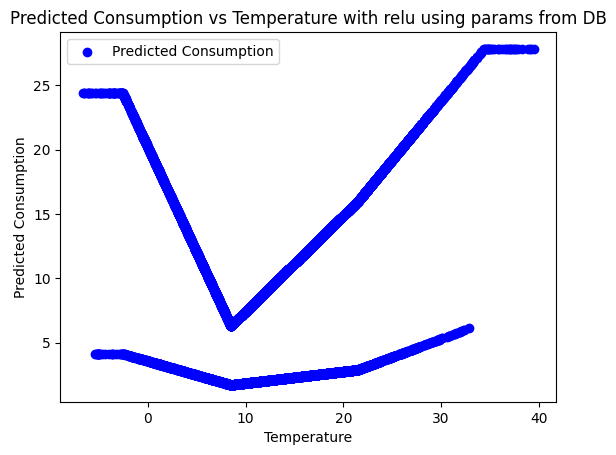

In [22]:
# Plotting the predictions so that we can see our 2 estimators (open and closed)

# Extract the 'temperature' and 'predicted_consumption' columns from the DataFrame
temperature = df_merged['temperature']
predicted_consumption = df_merged['predicted_consumption_param_relu']

# Create a scatter plot
plt.scatter(temperature, predicted_consumption, marker='o', color='b', label='Predicted Consumption')

# Add labels to the axes
plt.xlabel('Temperature')
plt.ylabel('Predicted Consumption')

# Add a title to the plot
plt.title('Predicted Consumption vs Temperature with relu using params from DB')

# Display a legend if needed
plt.legend()

# Show the plot
plt.show()

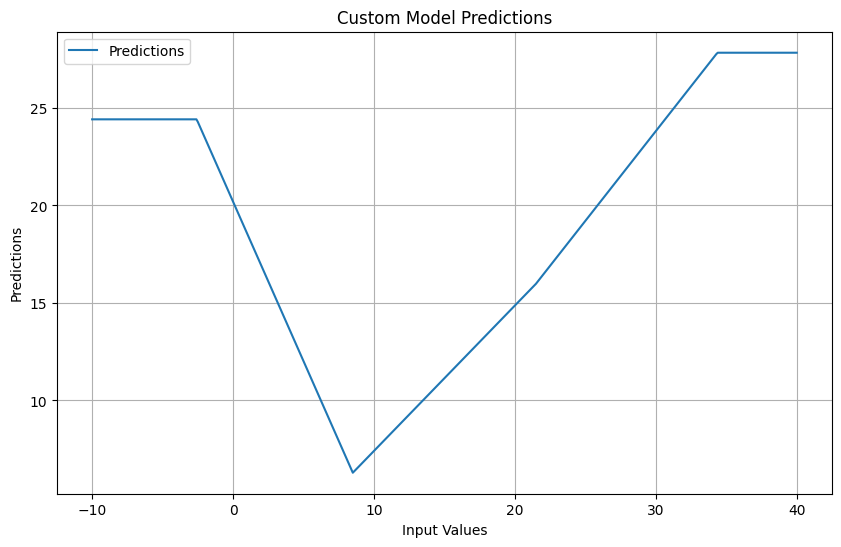

In [23]:
input_values = torch.arange(-10, 40.1, 0.1, dtype=torch.float32).view(-1, 1)

# Pass the input values through the model to obtain predictions
with torch.no_grad():
    predictions = OpenModel(input_values)

# Convert predictions to a NumPy array for plotting
predictions = predictions.numpy()

# Plot input values vs. predictions
plt.figure(figsize=(10, 6))
plt.plot(input_values.numpy(), predictions, label='Predictions', linestyle='-')
plt.xlabel('Input Values')
plt.ylabel('Predictions')
plt.title('Custom Model Predictions')
plt.grid(True)
plt.legend()
plt.show()

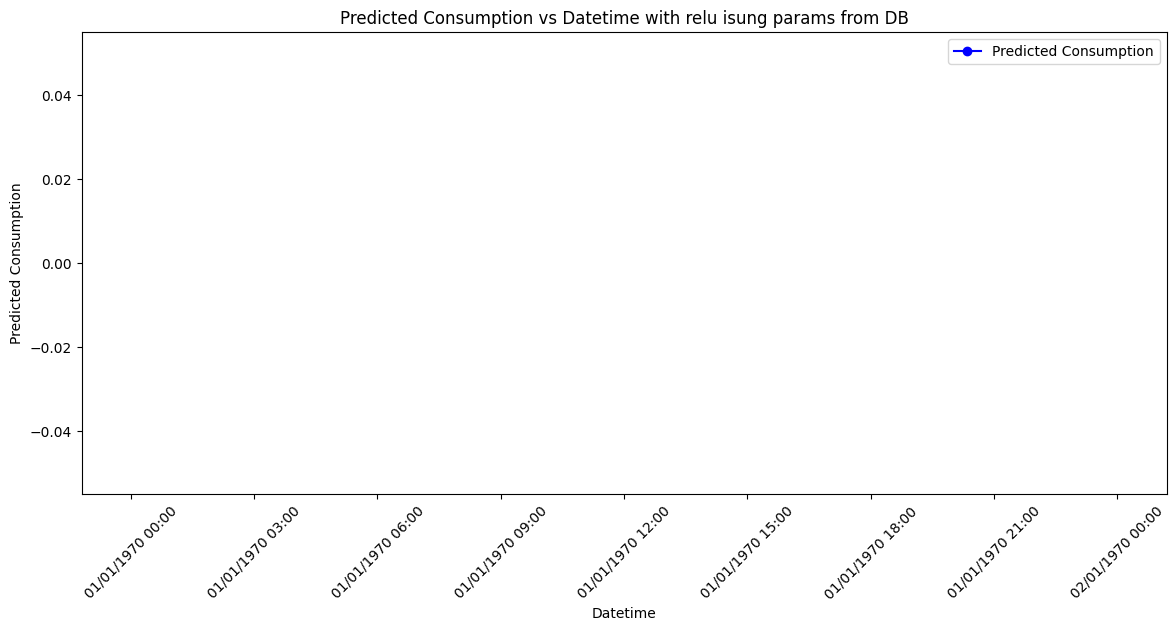

In [24]:
datetime = df_merged.loc[(df_merged['datetime'] > '2019-09-14') & (df_merged['datetime'] < '2019-09-17'),'datetime']
predicted_consumption = df_merged.loc[(df_merged['datetime'] > '2019-09-14') & (df_merged['datetime'] < '2019-09-17'),'predicted_consumption_param_relu']

# Create a plot of predicted consumption vs datetime
plt.figure(figsize=(14, 6))
plt.plot(datetime, predicted_consumption, marker='o', linestyle='-', color='b', label='Predicted Consumption')

# Create a DateFormatter to specify the date and time format
date_format = DateFormatter("%d/%m/%Y %H:%M")  # Example format: YYYY-MM-DD HH:MM:SS

# Apply the date format to the x-axis
plt.gca().xaxis.set_major_formatter(date_format)

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add labels to the axes
plt.xlabel('Datetime')
plt.ylabel('Predicted Consumption')

# Add a title to the plot
plt.title('Predicted Consumption vs Datetime with relu isung params from DB')

# Display a legend if needed
plt.legend()

# Show the plot
plt.show()


### Conclusion of test
There are differences between our model and the existing production models because the production models are discontinuous while our single layer perceptron will always produce a continuous piecewise linear.
Next we will compare a fitted perceptron to current productions models. For that we will make a piecewise linear function with parameters from existing models and compare to a fitted model.


## Fit linear NN to data and compare with piecewise linear

## Make piecewise linear function based on a to p parameters from DB

In [25]:
class PiecewiseEstimator:
  def __init__(self, id_site_global):

    df_model_params = get_model_parameters_df(id_site_global)

    for letter in 'abcdefghijklmnop':
        setattr(self, letter, df_model_params.at[0, letter])

  def open_piecewise(self,x):
    # Define breakpoints for the segments
    breakpoints = [self.m, self.n, self.o, self.p]

    # Define the slopes and offsets for each segment
    slopes = [self.a, self.c, self.e]
    offsets = [self.b, self.d, self.f]

    # Create the piecewise linear function using np.piecewise
    fx = np.piecewise(x, [x < breakpoints[0],
                        (x >= breakpoints[0]) & (x < breakpoints[1]),
                        (x >= breakpoints[1]) & (x < breakpoints[2]),
                        (x >= breakpoints[2]) & (x < breakpoints[3]),
                        x >= breakpoints[3]],
                    [lambda x:  slopes[0] * breakpoints[0] +  offsets[0],
                    lambda x:  slopes[0] * x +  offsets[0],
                    lambda x:  slopes[1] * x +  offsets[1],
                    lambda x:  slopes[2] * x +  offsets[2],
                    lambda x:  slopes[2] * breakpoints[3] +  offsets[2]])


    return fx

  def closed_piecewise(self,x):
    # Define breakpoints for the segments
    breakpoints = [self.m, self.n, self.o, self.p]

    # Define the slopes and offsets for each segment
    slopes = [self.g, self.i, self.k]
    offsets = [self.h, self.j, self.l]

    # Create the piecewise linear function using np.piecewise
    fx = np.piecewise(x, [x < breakpoints[0],
                        (x >= breakpoints[0]) & (x < breakpoints[1]),
                        (x >= breakpoints[1]) & (x < breakpoints[2]),
                        (x >= breakpoints[2]) & (x < breakpoints[3]),
                        x >= breakpoints[3]],
                    [lambda x:  slopes[0] * breakpoints[0] +  offsets[0],
                    lambda x:  slopes[0] * x +  offsets[0],
                    lambda x:  slopes[1] * x +  offsets[1],
                    lambda x:  slopes[2] * x +  offsets[2],
                    lambda x:  slopes[2] * breakpoints[3] +  offsets[2]])


    return fx

<ipython-input-11-4d7c046999e1>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_model_params = pd.read_sql(sql_query,mydb)


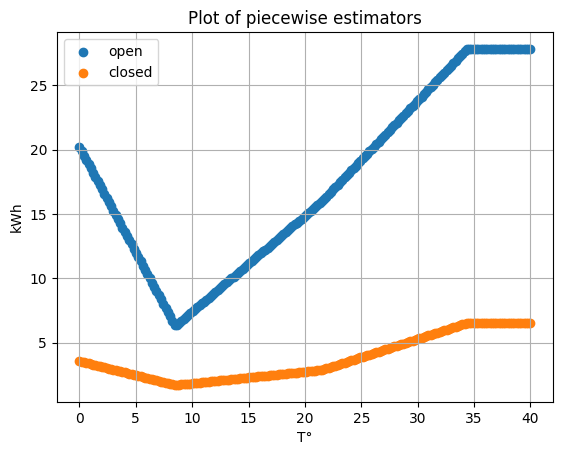

In [26]:
#from scipy import optimize
#import matplotlib.pyplot as plt
#import numpy as np
%matplotlib inline

piecewise_estimator = PiecewiseEstimator(id_site_global)

x = np.linspace(0, 40, 200)
y_open = piecewise_estimator.open_piecewise(x)
y_closed = piecewise_estimator.closed_piecewise(x)


# Plot f(x) and g(x)
plt.scatter(x, y_open, label='open')
plt.scatter(x, y_closed, label='closed')
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of piecewise estimators')
plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

## Fit linear NN to temperatures, consumption and opening hours data

#### Make DF with input and ground truths

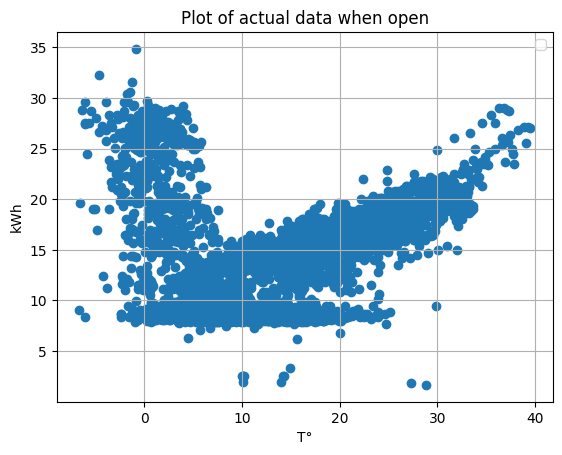

In [27]:
%matplotlib inline

x = df_merged.loc[df_merged['is_open']==True, 'temperature'].values
y = df_merged.loc[df_merged['is_open']==True, 'consumption'].values

# Plot f(x) and g(x)
plt.scatter(x, y)
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of actual data when open')
plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

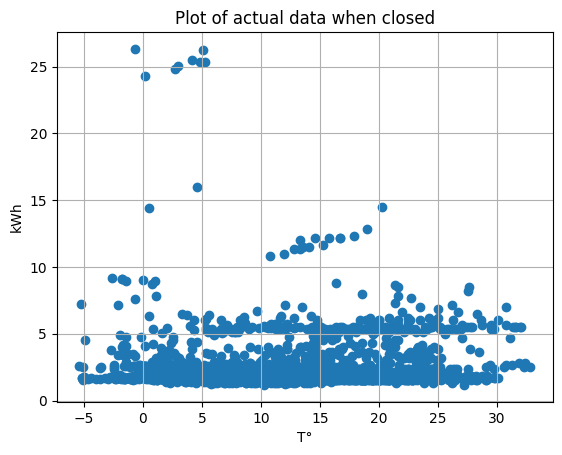

In [28]:
%matplotlib inline

x = df_merged.loc[df_merged['is_open']==False, 'temperature'].values
y = df_merged.loc[df_merged['is_open']==False, 'consumption'].values

# Plot f(x) and g(x)
plt.scatter(x, y)
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of actual data when closed')
#plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

#### Fit model to data and evaluate

##### When store is open

In [29]:
train_df, test_df = train_test_split(df_merged.loc[df_merged['is_open']==True, ['temperature', 'consumption']], test_size=0.3, random_state=42)

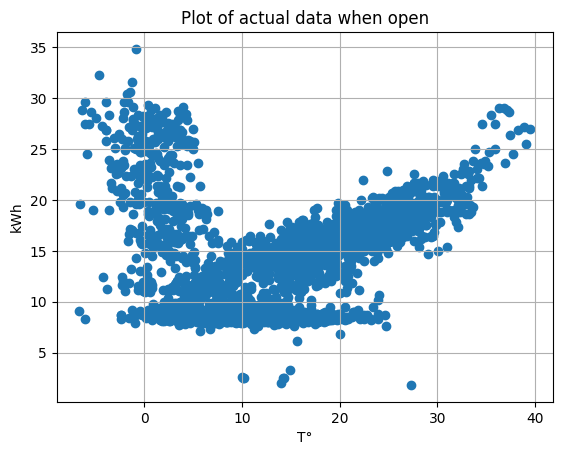

In [30]:
%matplotlib inline

x = train_df['temperature'].values
y = train_df['consumption'].values

# Plot f(x) and g(x)
plt.scatter(x, y)
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of actual data when open')
#plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

In [31]:
model_open = PrevisionalModelReluSimple()

In [32]:
# Choose hyperparameters
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-5  # Adjust this based on your problem and model complexity

# Define the optimizer with SGD and the selected hyperparameters
optimizer = optim.SGD(model_open.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Define loss function
criterion = torch.nn.L1Loss()  # Mean Squared Error loss for regression
#optimizer = optim.SGD(model_open.parameters(), lr=0.01)

# Training loop
epochs = 20000
for epoch in tqdm(range(epochs)):
    model_open.train()  # Set the model to training mode
    optimizer.zero_grad()
    inputs = torch.tensor(train_df['temperature'].values, dtype=torch.float32).view(-1, 1)
    targets = torch.tensor(train_df['consumption'].values, dtype=torch.float32).view(-1, 1)
    outputs = model_open(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # Print the loss every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

# Testing
model_open.eval()  # Set the model to evaluation mode
test_inputs = torch.tensor(test_df['temperature'].values, dtype=torch.float32).view(-1, 1)
test_targets = torch.tensor(test_df['consumption'].values, dtype=torch.float32).view(-1, 1)
test_outputs = model_open(test_inputs)

# Calculate MAE for testing
mae_loss = torch.nn.L1Loss()
mae = mae_loss(test_targets, test_outputs.detach())
print(f"MAE on Test Set: {mae}")

  6%|▌         | 1172/20000 [00:00<00:11, 1579.99it/s]

Epoch [1000/20000], Loss: 2.5458550453186035


 12%|█▏        | 2315/20000 [00:01<00:10, 1612.03it/s]

Epoch [2000/20000], Loss: 2.517441749572754


 16%|█▋        | 3255/20000 [00:02<00:11, 1516.93it/s]

Epoch [3000/20000], Loss: 2.512709140777588


 21%|██        | 4169/20000 [00:02<00:10, 1511.02it/s]

Epoch [4000/20000], Loss: 2.5088913440704346


 26%|██▋       | 5287/20000 [00:03<00:09, 1596.12it/s]

Epoch [5000/20000], Loss: 2.506852626800537


 31%|███       | 6249/20000 [00:04<00:09, 1527.20it/s]

Epoch [6000/20000], Loss: 2.5059196949005127


 35%|███▌      | 7087/20000 [00:05<00:15, 811.59it/s] 

Epoch [7000/20000], Loss: 2.505507469177246


 41%|████      | 8110/20000 [00:06<00:17, 661.95it/s]

Epoch [8000/20000], Loss: 2.505404472351074


 45%|████▌     | 9089/20000 [00:07<00:14, 767.14it/s]

Epoch [9000/20000], Loss: 2.505160331726074


 50%|█████     | 10079/20000 [00:09<00:12, 768.70it/s]

Epoch [10000/20000], Loss: 2.505051851272583


 55%|█████▌    | 11077/20000 [00:11<00:19, 457.13it/s]

Epoch [11000/20000], Loss: 2.5048465728759766


 61%|██████▏   | 12265/20000 [00:13<00:06, 1121.11it/s]

Epoch [12000/20000], Loss: 2.504687786102295


 66%|██████▌   | 13193/20000 [00:13<00:04, 1494.02it/s]

Epoch [13000/20000], Loss: 2.5048112869262695


 72%|███████▏  | 14303/20000 [00:14<00:03, 1569.48it/s]

Epoch [14000/20000], Loss: 2.5046987533569336


 76%|███████▋  | 15259/20000 [00:15<00:03, 1513.73it/s]

Epoch [15000/20000], Loss: 2.5045793056488037


 81%|████████  | 16194/20000 [00:15<00:02, 1555.85it/s]

Epoch [16000/20000], Loss: 2.50457501411438


 86%|████████▋ | 17263/20000 [00:16<00:01, 1495.02it/s]

Epoch [17000/20000], Loss: 2.504626512527466


 91%|█████████ | 18180/20000 [00:17<00:01, 1491.39it/s]

Epoch [18000/20000], Loss: 2.5047190189361572


 97%|█████████▋| 19308/20000 [00:18<00:00, 1595.47it/s]

Epoch [19000/20000], Loss: 2.5045583248138428


100%|██████████| 20000/20000 [00:18<00:00, 1083.44it/s]

Epoch [20000/20000], Loss: 2.5046088695526123
MAE on Test Set: 2.5508952140808105


In [33]:
#torch.save(model_open.state_dict(), '/content/drive/MyDrive/Colab/Models/model_open_1633_2019_simple_3.pth')

##### When store is closes

In [34]:
train_df, test_df = train_test_split(df_merged.loc[df_merged['is_open']==False, ['temperature', 'consumption']], test_size=0.3, random_state=42)
model_closed = PrevisionalModelReluSimple()

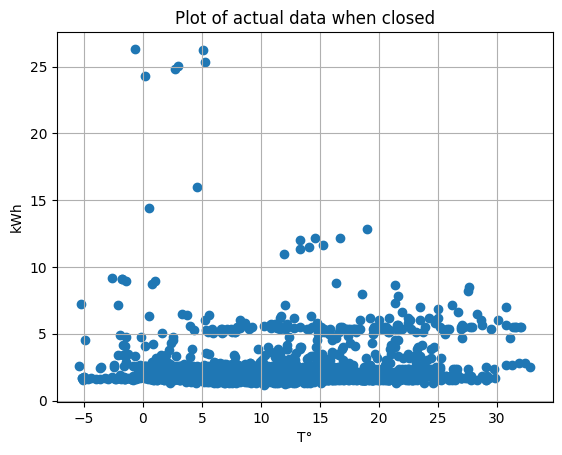

In [35]:
%matplotlib inline

x = train_df['temperature'].values
y = train_df['consumption'].values

# Plot f(x) and g(x)
plt.scatter(x, y)
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of actual data when closed')
#plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

In [36]:
# Define loss function and optimizer
criterion = torch.nn.L1Loss()  # Mean Squared Error loss for regression
optimizer = optim.SGD(model_closed.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Training loop
epochs = 20000
for epoch in tqdm(range(epochs)):
    model_closed.train()  # Set the model to training mode
    optimizer.zero_grad()
    inputs = torch.tensor(train_df['temperature'].values, dtype=torch.float32).view(-1, 1)
    targets = torch.tensor(train_df['consumption'].values, dtype=torch.float32).view(-1, 1)
    outputs = model_closed(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # Print the loss every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

# Testing
model_closed.eval()  # Set the model to evaluation mode
test_inputs = torch.tensor(test_df['temperature'].values, dtype=torch.float32).view(-1, 1)
test_targets = torch.tensor(test_df['consumption'].values, dtype=torch.float32).view(-1, 1)
test_outputs = model_closed(test_inputs)

# Calculate MAE for testing
mae_loss = torch.nn.L1Loss()
mae_closed_nn = mae_loss(test_targets, test_outputs.detach())
print(f"MAE on Test Set: {mae_closed_nn}")

  6%|▌         | 1180/20000 [00:00<00:12, 1545.88it/s]

Epoch [1000/20000], Loss: 0.8684836030006409


 11%|█         | 2164/20000 [00:01<00:11, 1613.39it/s]

Epoch [2000/20000], Loss: 0.8470115661621094


 17%|█▋        | 3344/20000 [00:02<00:09, 1702.97it/s]

Epoch [3000/20000], Loss: 0.8204864263534546


 21%|██        | 4204/20000 [00:02<00:09, 1704.96it/s]

Epoch [4000/20000], Loss: 0.7972184419631958


 26%|██▌       | 5238/20000 [00:03<00:08, 1711.28it/s]

Epoch [5000/20000], Loss: 0.781304121017456


 31%|███       | 6140/20000 [00:03<00:10, 1370.36it/s]

Epoch [6000/20000], Loss: 0.7578387260437012


 36%|███▋      | 7261/20000 [00:05<00:10, 1166.31it/s]

Epoch [7000/20000], Loss: 0.7577915787696838


 41%|████      | 8194/20000 [00:05<00:07, 1489.34it/s]

Epoch [8000/20000], Loss: 0.7577832341194153


 47%|████▋     | 9303/20000 [00:06<00:06, 1595.63it/s]

Epoch [9000/20000], Loss: 0.7577763199806213


 51%|█████▏    | 10285/20000 [00:07<00:06, 1588.69it/s]

Epoch [10000/20000], Loss: 0.7577647566795349


 56%|█████▋    | 11270/20000 [00:07<00:05, 1644.48it/s]

Epoch [11000/20000], Loss: 0.7577471137046814


 61%|██████▏   | 12268/20000 [00:08<00:04, 1635.18it/s]

Epoch [12000/20000], Loss: 0.757683515548706


 66%|██████▋   | 13289/20000 [00:09<00:04, 1624.23it/s]

Epoch [13000/20000], Loss: 0.7575578689575195


 72%|███████▏  | 14324/20000 [00:09<00:03, 1665.56it/s]

Epoch [14000/20000], Loss: 0.7571892142295837


 76%|███████▌  | 15166/20000 [00:10<00:02, 1628.38it/s]

Epoch [15000/20000], Loss: 0.756841778755188


 82%|████████▏ | 16316/20000 [00:10<00:02, 1610.58it/s]

Epoch [16000/20000], Loss: 0.7565158009529114


 87%|████████▋ | 17324/20000 [00:11<00:01, 1631.18it/s]

Epoch [17000/20000], Loss: 0.7562975287437439


 91%|█████████ | 18179/20000 [00:12<00:01, 1641.91it/s]

Epoch [18000/20000], Loss: 0.7562023997306824


 97%|█████████▋| 19337/20000 [00:12<00:00, 1622.05it/s]

Epoch [19000/20000], Loss: 0.7561290264129639


100%|██████████| 20000/20000 [00:13<00:00, 1518.61it/s]

Epoch [20000/20000], Loss: 0.7559680342674255
MAE on Test Set: 0.761585533618927


## Comparing the machine learning model with the manual production models

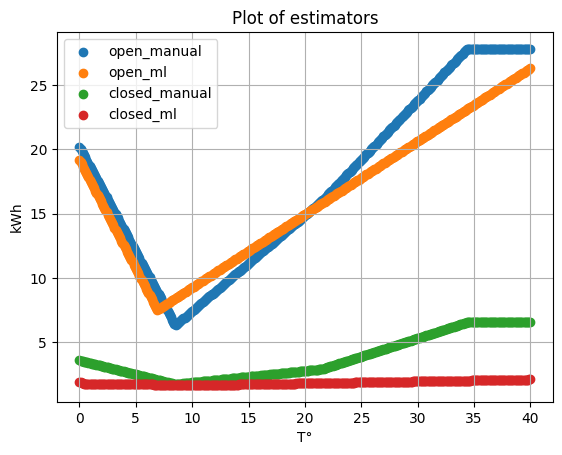

In [41]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.linspace(0, 40, 400)
y_open_manual = piecewise_estimator.open_piecewise(x)
y_closed_manual = piecewise_estimator.closed_piecewise(x)

input_values = torch.arange(0, 40, 0.1, dtype=torch.float32).view(-1, 1)

# Pass the input values through the model to obtain predictions
with torch.no_grad():
    y_open_ml = model_open(input_values)
    y_closed_ml = model_closed(input_values)

# Convert predictions to a NumPy array for plotting
y_open_ml = y_open_ml.numpy()
y_closed_ml = y_closed_ml.numpy()


# Plot f(x) and g(x)
plt.scatter(x, y_open_manual, label='open_manual')
plt.scatter(x, y_open_ml, label='open_ml')
plt.scatter(x, y_closed_manual, label='closed_manual')
plt.scatter(x, y_closed_ml, label='closed_ml')
plt.xlabel('T°')
plt.ylabel('kWh')
plt.title('Plot of estimators')
plt.legend()  # Display legend for the two functions
plt.grid(True)

# Show the plot
plt.show()

In [42]:
# Step 0 make predictions
test_inputs_closed =df_merged.loc[df_merged['is_open']==False, 'temperature'].values
test_targets_closed = df_merged.loc[df_merged['is_open']==False, 'consumption'].values
test_outputs_closed = piecewise_estimator.closed_piecewise(test_inputs_closed)

test_inputs_open =df_merged.loc[df_merged['is_open']==True, 'temperature'].values
test_targets_open = df_merged.loc[df_merged['is_open']==True, 'consumption'].values
test_outputs_open = piecewise_estimator.open_piecewise(test_inputs_open)


# Step 1: Calculate absolute errors
absolute_errors_closed = np.abs(test_targets_closed - test_outputs_closed)
summed_errors_closed = np.sum(test_targets_closed - test_outputs_closed)
absolute_errors_open = np.abs(test_targets_open - test_outputs_open)
summed_errors_open = np.sum(test_targets_open - test_outputs_open)

# Step 2: Compute the mean of absolute errors (MAE)
mae_closed = np.mean(absolute_errors_closed)
mae_open = np.mean(absolute_errors_open)

# Print the MAE
print("Mean Absolute Error for closed piecewise estimator:", mae_closed)
print("Mean Absolute Error for open piecewise estimator:", mae_open)

print("\nTotal summed Error for closed piecewise estimator:", summed_errors_closed)
print("Total summed Error for open piecewise estimator:", summed_errors_open)

Mean Absolute Error for closed piecewise estimator: 1.0655761323183215
Mean Absolute Error for open piecewise estimator: 2.8192716994599256

Total summed Error for closed piecewise estimator: -519.2008568168
Total summed Error for open piecewise estimator: 573.2457501392046


In [43]:
#Make predictions with closed model
model_closed.eval()  # Set the model to evaluation mode
test_inputs = torch.tensor(df_merged.loc[df_merged['is_open']==False, 'temperature'].values, dtype=torch.float32).view(-1, 1)
test_targets = torch.tensor(df_merged.loc[df_merged['is_open']==False, 'consumption'].values, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
  test_outputs = model_closed(test_inputs)

# Calculate MAE
mae_loss = torch.nn.L1Loss()
mae_closed_nn = mae_loss(test_targets, test_outputs.detach())
print("Mean Absolute Error for closed nn estimator:", mae_closed_nn)

summed_errors_closed = np.sum(test_targets.numpy() - test_outputs.numpy())

#Make predictions with open model
model_open.eval()  # Set the model to evaluation mode
test_inputs = torch.tensor(df_merged.loc[df_merged['is_open']==True, 'temperature'].values, dtype=torch.float32).view(-1, 1)
test_targets = torch.tensor(df_merged.loc[df_merged['is_open']==True, 'consumption'].values, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
  test_outputs = model_open(test_inputs)

# Calculate MAE
mae_loss = torch.nn.L1Loss()
mae_open_nn = mae_loss(test_targets, test_outputs.detach())
print("Mean Absolute Error for closed nn estimator:", mae_open_nn)

summed_errors_open = np.sum(test_targets.numpy() - test_outputs.numpy())

print("\nTotal summed Error for closed nn estimator:", summed_errors_closed)
print("Total summed Error for open nn estimator:", summed_errors_open)

Mean Absolute Error for closed nn estimator: tensor(0.7577)
Mean Absolute Error for closed nn estimator: tensor(2.5185)

Total summed Error for closed nn estimator: 1833.5798
Total summed Error for open nn estimator: 106.05945


We notice that the nn model has a total summed loss that is larger than that of the parametric piecewise production models. This could be because we are training with MAE which does not allow positive and negative errors to offset each other

In [44]:
#We could try to use this custom loss function which is simply total summed error (without abs.)

class SumErrorsLoss(torch.nn.Module):
    def __init__(self):
        super(SumErrorsLoss, self).__init__()

    def forward(self, predictions, targets):
        # Calculate the error as the difference between predictions and targets
        errors = predictions - targets

        # Sum all the errors without using absolute values
        loss = torch.sum(errors)

        return loss

# Example usage:
# Instantiate the loss function
custom_loss = SumErrorsLoss()

# Example predictions and targets
predictions = torch.tensor([2.0, -5.0, 3.0], requires_grad=True)
targets = torch.tensor([1.0, 3.0, 5.0], requires_grad=False)

# Calculate the loss
loss = custom_loss(predictions, targets)

# Backpropagation and optimization (if needed)
loss.backward()
# Now you can update your model's parameters if necessary


## Ideas for improvement


*   one hot encode month and day of the week data - currently this data is not used by the model at all
*   Make hours data cyclical with sine cosine transform : https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
*   Filter out badly tagged is_open (ie. due to false or missing exceptional closures). In our test the model tended to predict too much consumption in total during is_open times. This could be due to the fact that a couple of times that were tagged is_open the store was actually closed. We would predict high consumption believing it is open while real consumption is low because it is closed
*   Use time series forecasting tools like fb prophet



In [ ]:
# Let's calculate error for each row

### trying to make more complex fully connected nn


In [ ]:
class PrevisionalModelComplex(torch.nn.Module):

    def __init__(self):
      super(PrevisionalModelLearn, self).__init__()

      self.linear1 = torch.nn.Linear(1, 4)
      self.relu1 = torch.nn.ReLU()
      self.linear2 = torch.nn.Linear(4, 4)
      self.relu2 = torch.nn.ReLU()
      self.linear3 = torch.nn.Linear(4, 1)
      self.relu3 = torch.nn.ReLU()

    def forward(self, x):
      x = self.linear1(x)
      x = self.relu1(x)
      x = self.linear2(x)
      x = self.relu2(x)
      x = self.linear3(x)
      x = self.relu3(x)
      return x

In [ ]:
model = PrevisionalModelLearn()

# Define loss function and optimizer
criterion = torch.nn.SmoothL1Loss()  # MAE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.1)

NameError: ignored

In [ ]:
# Define loss function and optimizer
criterion = torch.nn.L1Loss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100000
for epoch in tqdm(range(epochs)):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    inputs = torch.tensor(train_df_open['temperature'].values, dtype=torch.float32).view(-1, 1)
    targets = torch.tensor(train_df_open['consumption'].values, dtype=torch.float32).view(-1, 1)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

# Testing
model.eval()  # Set the model to evaluation mode
test_inputs = torch.tensor(test_df['temperature'].values, dtype=torch.float32).view(-1, 1)
test_targets = torch.tensor(test_df['consumption'].values, dtype=torch.float32).view(-1, 1)
test_outputs = model(test_inputs)

# Calculate Mean Squared Error (MSE) for testing
mae_loss = torch.nn.L1Loss()
mae = mae_loss(test_targets, test_outputs.detach())
print(f"MAE on Test Set: {mae}")